Batch Normalization and Transfer Learning
===============

**Reference** : https://m.blog.naver.com/laonple/220808903260

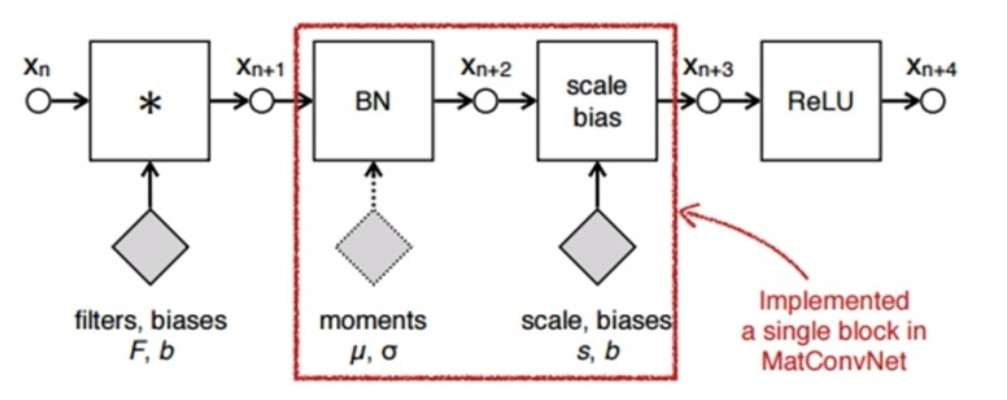

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('pictures/batch_normalization.jpg')
img

1. 딥러닝 학습 시 문제 발생  
-딥러닝을 통한 학습 시 ***vanishing/exploding gradient***가 발생  
-현재 layer의 입력은 모든 이전 layer의 파라미터의 변화에 영향을 받게 되며, 망이 깊어짐에 따라   
-이전 layer에서의 작은 파라미터 변화가 증폭되어 뒷단에 큰 영향을 끼치게 된다.  
-이를 ***Covariate Shift***라고 한다.   
-학습 과정에서는 분포가 비슷할수록 좋다.  
-whitening : 입력을 평균 0, 분산 1로 바꾸는 방식 --> 특정 파라미터가 계속 커지는 방식으로 진행될 수 있음

2. Batch Normalization   
- ***Batch Normalization***을 통해 문제 해결 가능
-신경망 안에 포함되어 training 시에 평균과 분산을 조정하는 과정 역시 같이 조절됨  
-조정은 mini batch 단위로 진행된다.  
-훈련 과정에서 평균과 분산을 구하여 정규를 진행한 후 scale과 shift 연산을 진행한다.   
-테스트 과정에서 scale과 shift 평균을 사용한다.  

Batch Normalization
---------

Text(0.5, 1.0, 'Backward Formula')

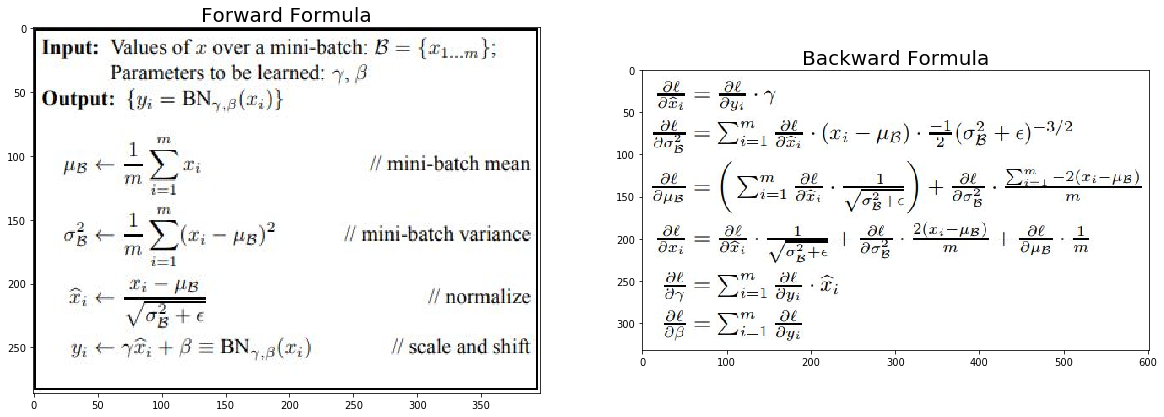

In [17]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
img1 = Image.open('pictures/BN_forward.JPG')
ax[0].imshow(img1)
ax[0].set_title('Forward Formula', fontsize=20)
img2 = Image.open('pictures/BN_backward.JPG')
ax[1].imshow(img2)
ax[1].set_title('Backward Formula', fontsize=20)

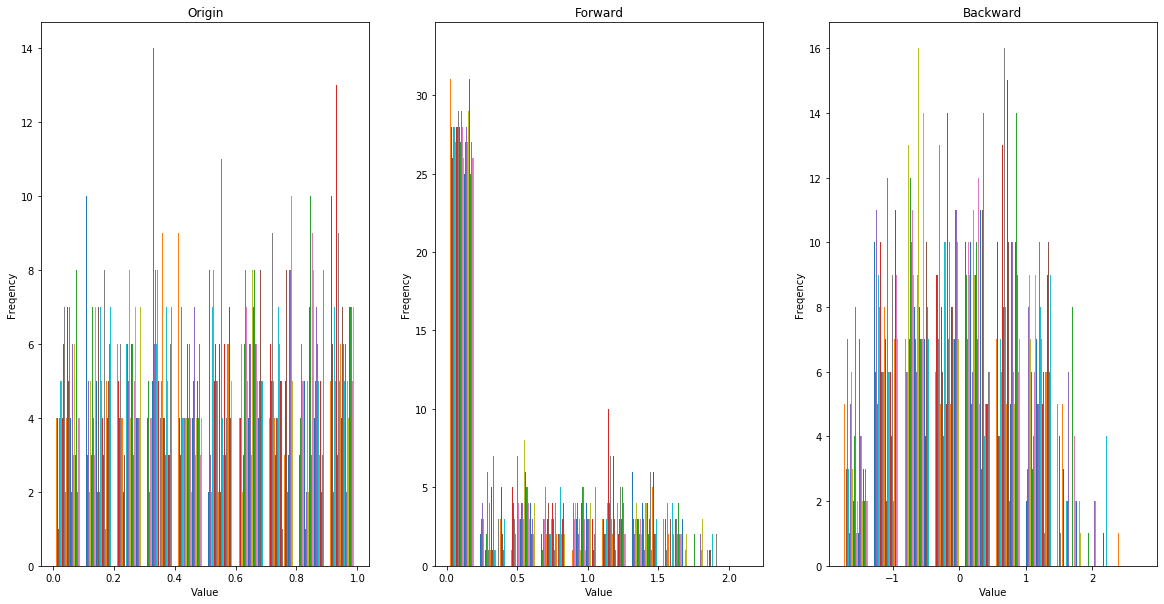

In [21]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# forward 메서드
def BN_forward(x, gamma, beta, eps):
    N, D = x.shape
    mu = 1./N * np.sum(x, axis = 0)
    xmu = x - mu
    var = 1./N * np.sum(xmu**2, axis = 0)
    sqrtvar = np.sqrt(var + eps)
    ivar = 1./sqrtvar
    xhat = xmu * ivar
    out = (gamma * xhat) + beta
    values = (xhat,gamma,xmu,ivar,sqrtvar,var,eps)
    return out, values

# Backward 메서드
def BN_backward(dout, cache):
    xhat,gamma,xmu,ivar,sqrtvar,var,eps = cache
    N,D = dout.shape
    
    # (dl/dgamma), (dl/dbeta)
    dbeta = np.sum(dout, axis=0)
    dgammax = dout
    dgamma = np.sum(dgammax*xhat, axis=0)
    
    # (dl/dxhat) 
    dxhat = dgammax * gamma
    
    # (dl/dvar) 
    divar = np.sum(dxhat*xmu, axis=0)
    dsqrtvar = -1. /(sqrtvar**2) * divar
    dvar = 0.5 * 1. /np.sqrt(var+eps) * dsqrtvar
    
    # (dl/dmu) 
    dxmu1 = dxhat * ivar
    dsq = 1. /N * np.ones((N,D)) * dvar
    dxmu2 = 2 * xmu * dsq
    
    dx1 = dxmu1 + dxmu2
    
    # (dl/dx)
    dmu = -1 * np.sum(dxmu1+dxmu2, axis=0)
    dx2 = 1. /N * np.ones((N,D)) * dmu
    
    dx = dx1 + dx2
    
    return dx, dgamma, dbeta

# ReLU Activation Function 메서드입니다.
def ReLU(x):
    return np.maximum(0,x)
    
def histogram(x, title):
    plt.hist(x)
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Freqency')
    plt.savefig('pictures/batch_normalization_plot.png')

# 임의의 batch x
np.random.seed(50)
x = np.random.rand(50,50)

plt.figure(figsize=(20,10))
plt.subplot(131)
# BN의 초기 파라미터를 설정
gamma, beta, epsilon = 1, 0, 10e-7
histogram(x, 'Origin')

# BN_forward
out, cache = BN_forward(x, gamma, beta, epsilon)

plt.subplot(132)
out = ReLU(out)
histogram(out,'Forward')

plt.subplot(133)
# BN_backward
dx, dgamma, dbeta = BN_backward(out, cache)
histogram(dx, 'Backward')

Batch Normalization by Keras
------------

uint8
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                100384    
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 10)                170       
Total params: 119,898
Trainable params: 119,898
Non-trainable params: 0
__________________________________________

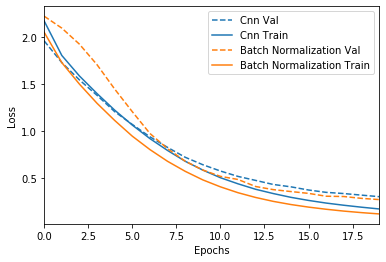

In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

def Visulaize(histories, key='loss'):
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])
    plt.savefig("pictures/batch_by_keras_plot.png")

    
# 1. Load data
mnist = np.load('./datasets/mnist.npz')
X_train, X_test, y_train, y_test = mnist['x_train'][:5000], mnist['x_test'][:1000], mnist['y_train'][:5000], mnist['y_test'][:1000]
print(X_train.dtype)

# 2. Data Preprocessing
# 2.1 normalization
# 2.2 차원 늘려주기
# 2.3 categorical로 target label 바꿔주기
X_train = X_train.astype(np.float32) / 255.
X_test = X_test.astype(np.float32) / 255.
X_train = np.expand_dims(X_train, axis=-1) # -1은 맨 뒤에 한 차원 늘려주기
X_test = np.expand_dims(X_test, axis=-1)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)  

# 3. Model 
# CNN(without batch)
CNN_model = keras.Sequential([
    keras.layers.Conv2D(32 ,kernel_size = (3,3), strides = (2,2), padding = 'same', activation=tf.nn.relu, input_shape=(28,28,1)),
    keras.layers.Conv2D(64 ,kernel_size = (3,3), strides = (2,2), padding = 'same', activation=tf.nn.relu),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation=tf.nn.sigmoid),
    keras.layers.Dense(16, activation=tf.nn.sigmoid),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

# CNN(with batch) -> batch normalization은 activation 이전에 적용해야함!
BN_model = keras.Sequential([
    keras.layers.Conv2D(32 ,kernel_size = (3,3), strides = (2,2), padding = 'same', input_shape=(28,28,1)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Conv2D(64 ,kernel_size = (3,3), strides = (2,2), padding = 'same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation=tf.nn.sigmoid),
    keras.layers.Dense(16, activation=tf.nn.sigmoid),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

# 4. compile model
CNN_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics = ['accuracy'])
CNN_model.summary()

# 5 train model 
# 5.1 train CNN(without batch)model
CNN_history = CNN_model.fit(X_train,y_train,epochs= 20, batch_size = 100, validation_data=(X_test, y_test), verbose=0)

# 5.2 train CNN(with batch) model
BN_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics = ['accuracy'])
BN_model.summary()
BN_history = BN_model.fit(X_train, y_train, epochs= 20, batch_size = 100, validation_data=(X_test, y_test), verbose=0)

# 6. visualize
Visulaize([('CNN', CNN_history),('Batch Normalization', BN_history)])

Transfer Learning
-------------

***Transfer Learning*** : 잘 훈련된 모델을 사용하여 유사한 문제를 해결하는 방법   

***필요한 이유***    
1. 학습을 위해서는 많은 데이터가 필요  
2. 모델의 일부분을 변경했을 때, 다시 전체를 학습하는 과정 필요  

Ensemble 방식으로 다른 구조의 nn을 학습하고 나오는 결과물을 합치는 과정의 방식이 있음  
Generalization 능력을 가진 신경망이 nn에 학습된 지식을 전달함으로써 가능  
distilling the ensemble knowledge를 통해 generalization 성능을 향상 할 수 있는 지식들 분리  
최종 출력은 softmax 활용하며, 파라미터 T를 추가하여 T가 높을수록 기존보다 더 soft한 확률 분포 얻을 수 있음  

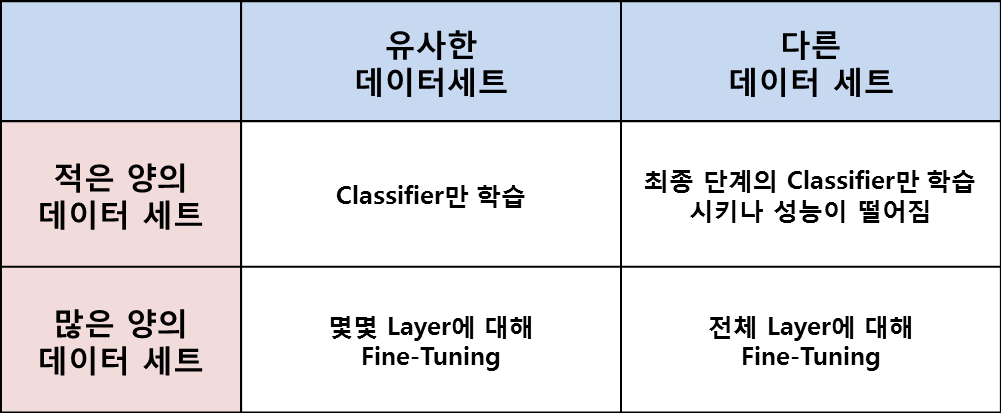

In [27]:
img = Image.open('pictures/tl.png')
img

1. 적은 양의 유사 데이터 - 데이터의 양이 적기 때문에 Overfitting을 방지하기 위해 뒤쪽의 Classifier만 학습  

3. 적은 양의 다른 데이터 - 데이터의 양이 적기 때문에 뒤쪽의 Classifier만 학습하지만 성능 향상을 기대하기 힘듬  

3. 많은 양의 유사 데이터 - Overfitting의 위험이 적으므로 전체 및 많은 Layer를 Fine-tuning  

4. 많은 양의 다른 데이터 - 데이터가 다르기 때문에 전체 모델을 Fine-tuning  

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                32800     
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_14 (Dense)             (None, 10)               

W0731 16:02:04.073821  4024 training.py:1952] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                32800     
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_14 (Dense)             (None, 10)               

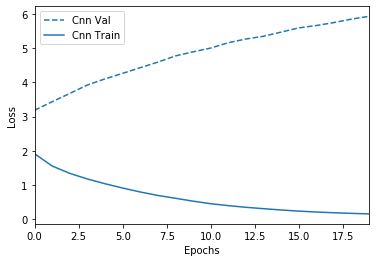

In [29]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

def Visulaize(histories, key='loss'):
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()
    plt.xlim([0,max(history.epoch)])
    plt.savefig("pictures/transfer_learning_plot.png")

# 1. load and split data
mnist = np.load('./datasets/mnist.npz')
X_train, X_test, y_train, y_test = mnist['x_train'][:5000], mnist['x_test'][:1000], mnist['y_train'][:5000], mnist['y_test'][:1000]

# 2. split label by 0~4, 5~9 for transfer learing
x_mnist_04 = []
y_mnist_04 = []
x_mnist_59 = []
y_mnist_59 = []
 
for idx, label in enumerate(y_train):
    if label <= 4:
        x_mnist_04.append(X_train[idx])
        y_mnist_04.append(y_train[idx])
        
    else:
        x_mnist_59.append(X_train[idx])
        y_mnist_59.append(y_train[idx])
        
# train by(0 ~ 4) labels and validate by (5 ~ 9) labels
X_train04, y_train04 = np.array(x_mnist_04), np.array(y_mnist_04)
X_test59, y_test59 = np.array(x_mnist_59), np.array(y_mnist_59)

# 3. data preprocessing 
X_train04 = X_train04.astype(np.float32) / 255.
X_test59 = X_test59.astype(np.float32) / 255.
X_train04 = np.expand_dims(X_train04, axis=-1)
X_test59 = np.expand_dims(X_test59, axis=-1)
y_train04 = to_categorical(y_train04, 10)
y_test59 = to_categorical(y_test59, 10)

# 4. model 
CNN_model = keras.Sequential([
    keras.layers.Conv2D(32 ,kernel_size = (3,3), strides = (2,2), padding = 'same', activation=tf.nn.relu, input_shape=(28,28,1)),
    keras.layers.Conv2D(64 ,kernel_size = (3,3), strides = (2,2), padding = 'same', activation=tf.nn.relu),
    keras.layers.Conv2D(64 ,kernel_size = (3,3), strides = (2,2), padding = 'same', activation=tf.nn.relu),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation=tf.nn.sigmoid),
    keras.layers.Dense(16, activation=tf.nn.sigmoid),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

# 5. compile and train model
CNN_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics = ['accuracy'])
CNN_model.summary()

CNN_history = CNN_model.fit(X_train04, y_train04,epochs= 20, batch_size = 100, validation_data=(X_test59, y_test59), verbose=0)

# 6. visualize
Visulaize([('CNN', CNN_history)])


################################################################################
# Transfer Learning
# drop Dense, Flatten layer for transfer learning
# 유사한 숫자 데이터이면서 적은 양의 데이터를 가지고 있기 때문에 classifier만 재학습!!!

CNN_model.summary()

for i in range(0,4):
    CNN_model.pop()

CNN_model.summary()

# save weights of conv layer
CNN_model.save_weights('datasets/CNN_model.h5', save_format='h5')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_6 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_20 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_21 (Dense)             (None, 32)               

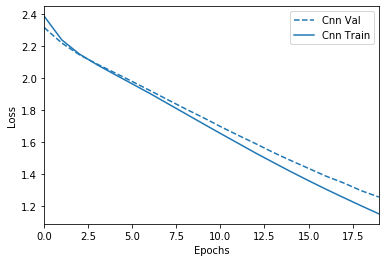

In [33]:
mnist = np.load('./datasets/mnist.npz')
X_train, X_test, y_train, y_test = mnist['x_train'][:500], mnist['x_test'][:500], mnist['y_train'][:500], mnist['y_test'][:500]


X_train = X_train.astype(np.float32) / 255.
X_test = X_test.astype(np.float32) / 255.
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# 이전 실습에서 사용했던 CNN_model과 같은 구조를 가진 모델을 선언
# 저장된 Weights를 불러오기 위해서는 모델의 구조가 같아야함
Transfer_model = keras.Sequential([
    keras.layers.Conv2D(32 ,kernel_size = (3,3), strides = (2,2), padding = 'same', activation=tf.nn.relu, input_shape=(28,28,1)),
    keras.layers.Conv2D(64 ,kernel_size = (3,3), strides = (2,2), padding = 'same', activation=tf.nn.relu),
    keras.layers.Conv2D(64 ,kernel_size = (3,3), strides = (2,2), padding = 'same', activation=tf.nn.relu)
])


Transfer_model.load_weights('datasets/CNN_model.h5') 

# TODO : 새로운 Classifier를 Transfer_model에 붙여주기
Transfer_model.add(keras.layers.Flatten())
Transfer_model.add(keras.layers.Dense(128, activation=tf.nn.sigmoid))
Transfer_model.add(keras.layers.Dense(64, activation=tf.nn.sigmoid))
Transfer_model.add(keras.layers.Dense(32, activation=tf.nn.sigmoid))
Transfer_model.add(keras.layers.Dense(10, activation=tf.nn.softmax))

# Transfer_model을 출력
Transfer_model.summary()


# 전체 모델에서 Classifier 부분만 학습하기 위해 Trainable 여부를 설정할 수 있음
# TODO : 앞의 Convolution layer는 학습에서 제외하고 뒤의 Classifier 부분만 학습하기 위해 Trainable을 알맞게 설정
for layer in Transfer_model.layers[:3]:
    layer.trainable = False
for layer in Transfer_model.layers[3:]:
    layer.trainable = True

# Transfer_model을 학습
Transfer_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics = ['accuracy'])
Transfer_history = Transfer_model.fit(X_train, y_train, epochs= 20, batch_size = 100, validation_data=(X_test, y_test), verbose=0)

Visulaize([('CNN', Transfer_history)])